This notebook checks our windows against those used in Freeman and Simoncelli, 2011, to make sure our implementation doesn't differ too much. In order to use this, first run the `freeman_check` rule in Snakemake (or, if you don't have matlab or don't wish to set it up, download the outputs from OSF using `download_freeman_check` Snakemake rule)

# Download

In [1]:
import pyrtools as pt
import plenoptic as po
import os.path as op
import matplotlib.pyplot as plt
import h5py

import sys
sys.path.append('../extra_packages/pooling-windows/')
import pooling

%matplotlib inline
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

import yaml

with open('../config.yml') as f:
    DATA_DIR = yaml.safe_load(f)['DATA_DIR']

# Check windows

Let's do some quick checks to make sure our windows are comparable to the original implementation.

## Scaling 0.5

In [133]:
with h5py.File(op.join(DATA_DIR, 'freeman_windows/scaling-0.5/plotwindows.mat'), 'r') as f:
    im = f['im'][:]
    
with h5py.File(op.join(DATA_DIR, 'freeman_windows/scaling-0.5/masks.mat'), 'r') as f:
    masks = f[f['scale'][1, 0]]['maskMat'][:]

Those windows were created with a scaling value of .5, on a 512x512 image, maximum eccentricity of 13 degrees, 4 scales. So we'll create our equivalent one:

In [128]:
pw = pooling.PoolingWindows(.5, (512, 512), max_eccentricity=13, num_scales=4)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 2 with min_ecc 0.5, but calculated min_ecc is 0.648281205652328, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 3 with min_ecc 0.5, but calculated min_ecc is 1.296562411304656, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


On the left, this is the windows, as created by the `plotWindows` function in the [metamers](https://github.com/freeman-lab/metamers/) matlab code. I'm not entirely sure what the black and white correspond to, but it shows the approximate size. The right shows our windows, as created by [pooling-windows](https://github.com/LabForComputationalVision/pooling-windows) and used in our models. You can see they look approximately the same, but it's hard to directly compare.

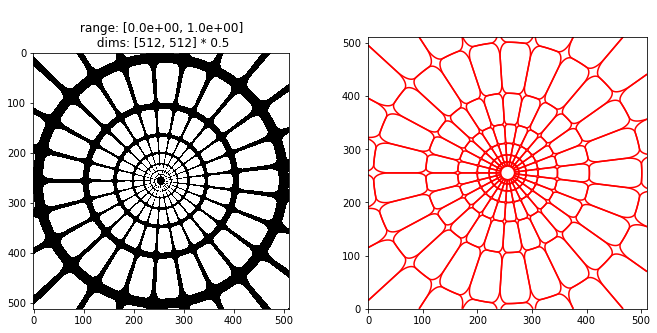

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
pt.imshow([im[0]], ax=axes[0], zoom=.5);
pw.plot_windows(subset=False, ax=axes[1]);

Let's pick an arbitrary window from the matlab code and investigate it more closely:

In [ ]:
mat_win = masks[..., -85]

Let's grab the window in approximately the same place from our windows. After a bit of trial and error, determined that the following is correct.

In [142]:
win = po.to_numpy(pw.ecc_windows[1][4])*po.to_numpy(pw.angle_windows[1][5])
# normalize so that max value is 1, to match matlab implementation
win /= win.max()

Now let's plot the two windows next to each other and then take their difference. We can see that they look the same, though, from their difference, it's clear that they're exact angular position doesn't line up. Their length in the radial direction appears to be the same, as does their width in the angular direction

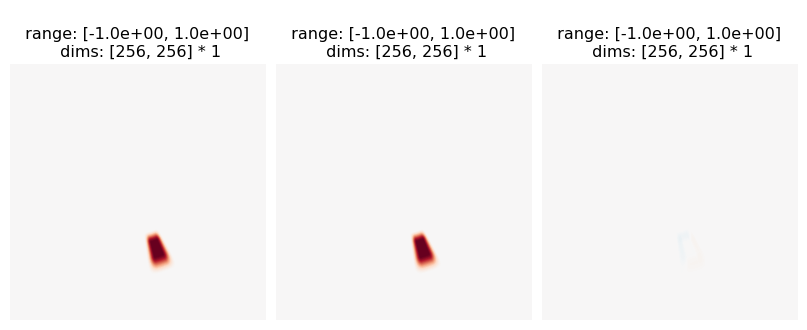

In [156]:
pt.imshow([mat_win, win, mat_win-win], vrange='auto0', );

We don't actually use these raised-cosine windows, though, so let's look at one of our Gaussian ones:

In [157]:
pw_gauss = pooling.PoolingWindows(.5, (512, 512), max_eccentricity=13, num_scales=5, 
                                  window_type='gaussian', std_dev=1)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 4 with min_ecc 0.5, but calculated min_ecc is 2.593124822609312, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


Again, pick the corresponding window. Note that indices are different here from above because there are far more Gaussian windows necessary to tile the image.

In [158]:
win_gauss = po.to_numpy(pw_gauss.ecc_windows[1][11])*po.to_numpy(pw_gauss.angle_windows[1][12])
# normalize so that max value is 1, to match matlab implementation
win_gauss /= win_gauss.max()

Do the same plot as above. Since the shape is different, it's a bit more difficult to decide whether we think they're the same size or not.

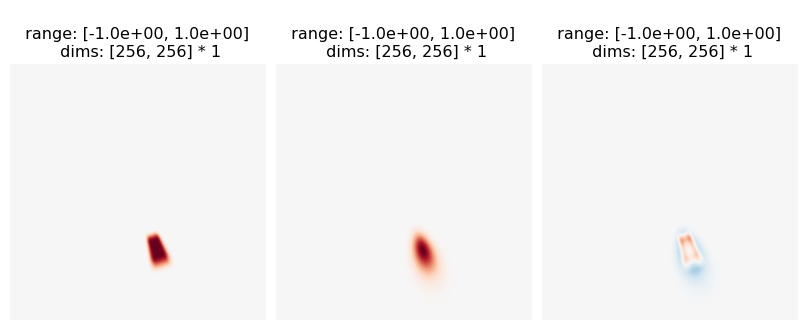

In [159]:
pt.imshow([mat_win, win_gauss, mat_win-win_gauss], vrange='auto0', );

Because of that, let's look at the sizes directly. Since we trust our raised-cosine windows are the same size as Jeremy's matlab implementation, let's compare our Gaussian windows directly to that, in both the radial and angular directions (in pixels). Note we're comparing the width at half-height, because that's how scaling is defined.

In [160]:
cos_r = pw.window_width_pixels[1]['radial_half'][4]
cos_a = pw.window_width_pixels[1]['angular_half'][4]
gauss_a = pw_gauss.window_width_pixels[1]['angular_half'][11]
gauss_r = pw_gauss.window_width_pixels[1]['radial_half'][11]
print(f"Raised-cosine window has widths:\n\tradial: {cos_r:.03f}\n\tangular: {cos_a:.03f}")
print(f"Gaussian window has widths:\n\tradial: {gauss_r:.03f}\n\tangular: {gauss_a:.03f}")

Raised-cosine window has widths:
	radial: 29.237
	angular: 14.619
Gaussian window has widths:
	radial: 30.659
	angular: 15.330


And they're pretty much the same (the small difference is due to the fact that their centers aren't in exactly the same location.

In [161]:
cos_ctr = pw.central_eccentricity_pixels[1][4]
gauss_ctr = pw_gauss.central_eccentricity_pixels[1][11]
print(f"Raised-cosine window has center at {cos_ctr:.03f} pixels")
print(f"Gaussian window has center at {gauss_ctr:.03f} pixels")

Raised-cosine window has center at 58.475 pixels
Gaussian window has center at 61.318 pixels


## Scaling 0.25

Now let's do that whole thing over again with scaling 0.25. Text is basically just duplicated from above.

In [2]:
with h5py.File(op.join(DATA_DIR, 'freeman_windows/scaling-0.25/plotwindows.mat'), 'r') as f:
    im = f['im'][:]
    
with h5py.File(op.join(DATA_DIR, 'freeman_windows/scaling-0.25/masks.mat'), 'r') as f:
    masks = f[f['scale'][1, 0]]['maskMat'][:]

In [3]:
pw = pooling.PoolingWindows(.25, (512, 512), max_eccentricity=13, num_scales=4)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 1 with min_ecc 0.5, but calculated min_ecc is 0.648281205652328, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 2 with min_ecc 0.5, but calculated min_ecc is 1.296562411304656, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 3 with min_ecc 0.5, but calculated min_ecc is 2.593124822609312, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "


On the left, this is the windows, as created by the `plotWindows` function in the [metamers](https://github.com/freeman-lab/metamers/) matlab code. I'm not entirely sure what the black and white correspond to, but it shows the approximate size. The right shows our windows, as created by [pooling-windows](https://github.com/LabForComputationalVision/pooling-windows) and used in our models. You can see they look approximately the same, but it's hard to directly compare.

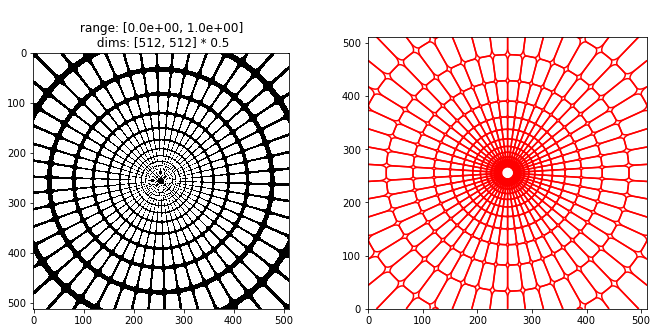

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
pt.imshow([im[0]], ax=axes[0], zoom=.5);
pw.plot_windows(subset=False, ax=axes[1]);

Let's pick an arbitrary window from the matlab code and investigate it more closely:

In [35]:
mat_win = masks[..., -355]

Let's grab the window in approximately the same place from our windows. After a bit of trial and error, determined that the following is correct.

In [36]:
win = po.to_numpy(pw.ecc_windows[1][10])*po.to_numpy(pw.angle_windows[1][11])
# normalize so that max value is 1, to match matlab implementation
win /= win.max()

Now let's plot the two windows next to each other and then take their difference. We can see that they look the same, though, from their difference, it's clear that they're exact angular position doesn't line up. Their length in the radial direction appears to be the same, as does their width in the angular direction

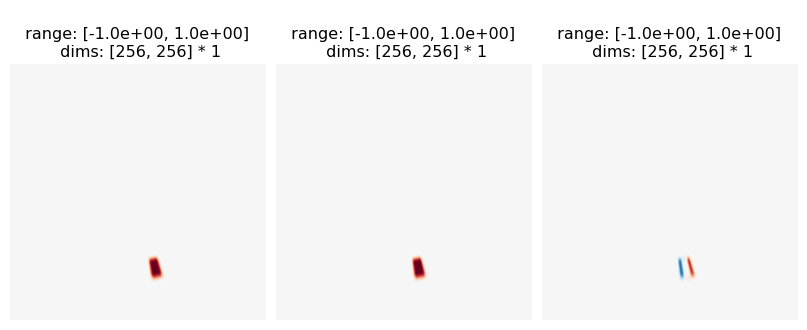

In [37]:
pt.imshow([mat_win, win, mat_win-win], vrange='auto0', );

We don't actually use these raised-cosine windows, though, so let's look at one of our Gaussian ones:

In [47]:
pw_gauss = pooling.PoolingWindows(.25, (512, 512), max_eccentricity=13, num_scales=5, 
                                  window_type='gaussian', std_dev=1)

../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 1 with min_ecc 0.5, but calculated min_ecc is 0.648281205652328, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 2 with min_ecc 0.5, but calculated min_ecc is 1.296562411304656, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 3 with min_ecc 0.5, but calculated min_ecc is 2.593124822609312, so be aware some are smaller than a pixel!
  warnings.warn(f"Creating windows for scale {i} with min_ecc "
../extra_packages/pooling-windows/pooling/pooling_windows.py:280: UserWarning: Creating windows for scale 4 with min_ecc 0.5, but calculated min_ecc is 5.186249645218

Again, pick the corresponding window. Note that indices are different here from above because there are far more Gaussian windows necessary to tile the image.

In [56]:
win_gauss = po.to_numpy(pw_gauss.ecc_windows[1][25])*po.to_numpy(pw_gauss.angle_windows[1][25])
# normalize so that max value is 1, to match matlab implementation
win_gauss /= win_gauss.max()

Do the same plot as above. Since the shape is different, it's a bit more difficult to decide whether we think they're the same size or not.

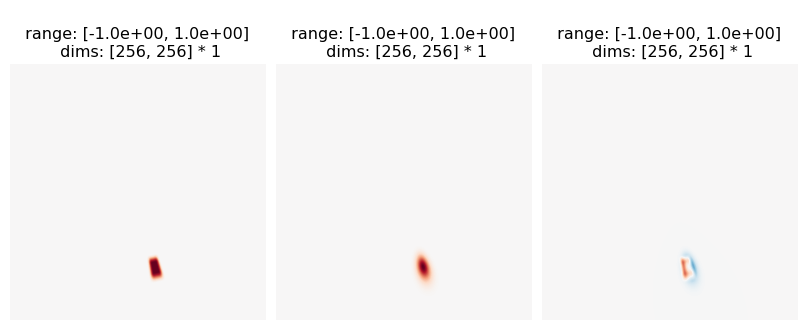

In [57]:
pt.imshow([mat_win, win_gauss, mat_win-win_gauss], vrange='auto0', );

Because of that, let's look at the sizes directly. Since we trust our raised-cosine windows are the same size as Jeremy's matlab implementation, let's compare our Gaussian windows directly to that, in both the radial and angular directions (in pixels). Note we're comparing the width at half-height, because that's how scaling is defined.

In [58]:
cos_r = pw.window_width_pixels[1]['radial_half'][10]
cos_a = pw.window_width_pixels[1]['angular_half'][10]
gauss_a = pw_gauss.window_width_pixels[1]['angular_half'][25]
gauss_r = pw_gauss.window_width_pixels[1]['radial_half'][25]
print(f"Raised-cosine window has widths:\n\tradial: {cos_r:.03f}\n\tangular: {cos_a:.03f}")
print(f"Gaussian window has widths:\n\tradial: {gauss_r:.03f}\n\tangular: {gauss_a:.03f}")

Raised-cosine window has widths:
	radial: 19.116
	angular: 9.558
Gaussian window has widths:
	radial: 19.313
	angular: 9.657


And they're pretty much the same (the small difference is due to the fact that their centers aren't in exactly the same location.

In [59]:
cos_ctr = pw.central_eccentricity_pixels[1][10]
gauss_ctr = pw_gauss.central_eccentricity_pixels[1][25]
print(f"Raised-cosine window has center at {cos_ctr:.03f} pixels")
print(f"Gaussian window has center at {gauss_ctr:.03f} pixels")

Raised-cosine window has center at 76.464 pixels
Gaussian window has center at 77.253 pixels
